<a href="https://colab.research.google.com/github/ajosegun/Pix2Pix-GAN/blob/main/02_Pix2Pix_GAN_for_Image_to_Image_Translation_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import cv2
import os
from os import listdir
import numpy as np

import random

from numpy import asarray, vstack, savez_compressed
from keras.utils import img_to_array, load_img

In [5]:
## Drive path
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Path to the dataset
# prepared_img = "/content/gdrive/MyDrive/Colab Notebooks/aivancity/Computer Vision/dataset/celeb_gan/celeb_256.npz"
prepared_img = "/content/gdrive/MyDrive/comp_vision_project/drive-download-20230502T151851Z-001.zip (Unzipped Files)/celeb_256.npz"


We can load the prepared dataset and summarize the shape of each array, confirming our expectations of a  set of 256×256 image pairs.

In [8]:
# load the prepared dataset
from numpy import load


# Path to save the prepared_img dataset
# prepared_img = "/content/gdrive/MyDrive/Colab Notebooks/aivancity/Computer Vision/dataset/celeb_gan/celeb_256.npz"

# load the dataset
data = load(prepared_img)
real_images, cartoon_images = data['arr_0'], data['arr_1']
print('Loaded: ', real_images.shape, cartoon_images.shape)


Loaded:  (2001, 256, 256, 3) (2001, 256, 256, 3)


We can then plot some images pairs to confirm the data has been handled correctly.

A plot of 3 image pairs is also created showing the real images on the top and cartoon images on the bottom.



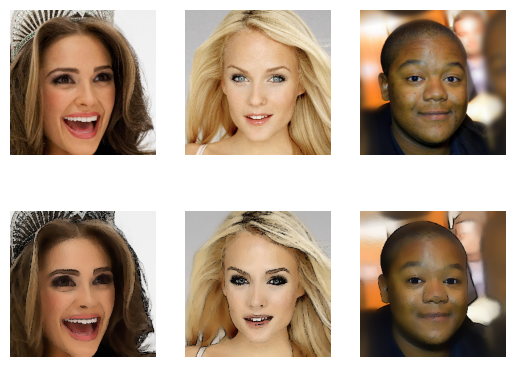

In [9]:
from matplotlib import pyplot

# plot real images
n_samples = 3
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(real_images[i].astype('uint8'))

# plot cartoon image
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + n_samples + i)
 pyplot.axis('off')
 pyplot.imshow(cartoon_images[i].astype('uint8'))

pyplot.show()

Now that we have prepared the dataset for image translation, we can develop our Pix2Pix GAN model.

### Develop and Train a Pix2Pix Model


The architecture is comprised of two models: the discriminator and the generator.

--------

The discriminator is a deep convolutional neural network that performs image classification. Specifically, conditional-image classification. It takes both the source image (e.g. real photo) and the target image (e.g. cartoon image) as input and predicts the likelihood of whether target image is real or a fake translation of the source image.

In [10]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load, zeros, ones
from numpy.random import randint

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, \
Concatenate, Dropout, BatchNormalization, LeakyReLU
from matplotlib import pyplot

In [7]:
# define the discriminator model
def define_discriminator(image_shape):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 
 # source image input
 in_src_image = Input(shape=image_shape)
 
 # target image input
 in_target_image = Input(shape=image_shape)
 
 # concatenate images channel-wise
 merged = Concatenate()([in_src_image, in_target_image])
 
 # C64
 d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
 d = LeakyReLU(alpha=0.2)(d)
 
 # C128
 d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 
 # C256
 d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 
 # C512
 d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 
 # second last output layer
 d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 
 # patch output
 d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
 patch_out = Activation('sigmoid')(d)
 
 # define model
 model = Model([in_src_image, in_target_image], patch_out)
 
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
 
 return model

In [8]:
d_model=define_discriminator(image_shape=(256, 256, 3))

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
d_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [10]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  
  # add downsampling layer
  g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  
  # conditionally add batch normalization
  if batchnorm:
    g = BatchNormalization()(g, training=True)
  
  # leaky relu activation
  g = LeakyReLU(alpha=0.2)(g)
  
  return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  # weight initialization
  init = RandomNormal(stddev=0.02)

  # add upsampling layer
  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

  # add batch normalization
  g = BatchNormalization()(g, training=True)

  # conditionally add dropout
  if dropout:
    g = Dropout(0.5)(g, training=True)

  # merge with skip connection
  g = Concatenate()([g, skip_in])

  # relu activation
  g = Activation('relu')(g)

  return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
  # weight initialization
  init = RandomNormal(stddev=0.02)

  # image input
  in_image = Input(shape=image_shape)

  # encoder model
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)

  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)

  # decoder model
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)

  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)

  # define model
  model = Model(in_image, out_image)
  
  return model

In [11]:
g_model=define_generator(image_shape=(256,256,3))

In [12]:
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  3136        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_6[0][0]']               
                                )                                                           

In [13]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
  # make weights in the discriminator not trainable
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False

  # define the source image
  in_src = Input(shape=image_shape)

  # connect the source image to the generator input
  gen_out = g_model(in_src)

  # connect the source input and generator output to the discriminator input
  dis_out = d_model([in_src, gen_out])

  # src image as input, generated image and classification output
  model = Model(in_src, [dis_out, gen_out])
  
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
  
  return model

In [14]:
gan_model=define_gan(g_model, d_model, image_shape=(256,256,3))

In [15]:
gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 256, 256, 3)  54429315    ['input_4[0][0]']                
                                                                                                  
 model (Functional)             (None, 16, 16, 1)    6968257     ['input_4[0][0]',                
                                                                  'model_1[0][0]']                
                                                                                            

Next, we can load our paired images dataset in compressed NumPy array format.

This will return a list of two NumPy arrays: the first for source images and the second for corresponding target images.

In [1]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
 
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']

	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
  
	return [X1, X2]

In [17]:
dataset_samples=load_real_samples(prepared_img)

Training the discriminator will require batches of real and fake images.

The generate_real_samples() function below will prepare a batch of random pairs of images from the training dataset, and the corresponding discriminator label of class=1 to indicate they are real.

In [2]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
  # unpack dataset
  trainA, trainB = dataset

  # choose random instances
  ix = randint(0, trainA.shape[0], n_samples)

  # retrieve selected images
  X1, X2 = trainA[ix], trainB[ix]

  # generate 'real' class labels (1)
  y = ones((n_samples, patch_shape, patch_shape, 1))
  
  return [X1, X2], y

The generate_fake_samples() function below uses the generator model and a batch of real source images to generate an equivalent batch of target images for the discriminator.

These are returned with the label class-0 to indicate to the discriminator that they are fake.

In [3]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

The summarize_performance() function implements this, taking the generator model at a point during training and using it to generate a number, in this case three, of translations of randomly selected images in the dataset. The source, generated image, and expected target are then plotted as three rows of images and the plot saved to file. Additionally, the model is saved to an H5 formatted file that makes it easier to load later.

In [20]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = '/content/gdrive/MyDrive/comp_vision_project/plot_2_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = '/content/gdrive/MyDrive/comp_vision_project/model_2_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [21]:
summarize_performance(10, g_model, dataset_samples, n_samples=3)

1/1 [==============================] - 9s 9s/step


>Saved: /content/gdrive/MyDrive/comp_vision_project/plot_000011.png and /content/gdrive/MyDrive/comp_vision_project/model_000011.h5


In [22]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)
			print('Model saved at step',i+1)

In [23]:
train(d_model, g_model, gan_model, dataset_samples, n_epochs=100, n_batch=1)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 24ms/step
>17512, d1[0.208] d2[0.257] g[6.365]
1/1 [==============================] - 0s 23ms/step
>17513, d1[0.254] d2[0.450] g[5.189]
1/1 [==============================] - 0s 24ms/step
>17514, d1[0.336] d2[0.346] g[5.367]
1/1 [==============================] - 0s 23ms/step
>17515, d1[0.106] d2[0.177] g[6.725]
1/1 [==============================] - 0s 24ms/step
>17516, d1[0.300] d2[0.297] g[6.188]
1/1 [==============================] - 0s 23ms/step
>17517, d1[0.115] d2[0.309] g[6.240]
1/1 [==============================] - 0s 24ms/step
>17518, d1[0.592] d2[0.191] g[4.282]
1/1 [==============================] - 0s 23ms/step
>17519, d1[0.534] d2[0.184] g[6.153]
1/1 [==============================] - 0s 24ms/step
>17520, d1[0.426] d2[0.261] g[3.649]
1/1 [==============================] - 0s 23ms/step
>17521, d1[0.193] d2[0.468] g[4.675]
1/1 [===========================

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 22ms/step
>37522, d1[0.317] d2[0.299] g[4.554]
1/1 [==============================] - 0s 22ms/step
>37523, d1[0.258] d2[0.428] g[4.401]
1/1 [==============================] - 0s 23ms/step
>37524, d1[0.205] d2[0.517] g[4.469]
1/1 [==============================] - 0s 24ms/step
>37525, d1[0.287] d2[0.534] g[3.071]
1/1 [==============================] - 0s 22ms/step
>37526, d1[0.246] d2[0.343] g[5.650]
1/1 [==============================] - 0s 22ms/step
>37527, d1[0.271] d2[0.340] g[5.575]
1/1 [==============================] - 0s 22ms/step
>37528, d1[0.334] d2[0.320] g[5.332]
1/1 [==============================] - 0s 22ms/step
>37529, d1[0.285] d2[0.297] g[5.639]
1/1 [==============================] - 0s 23ms/step
>37530, d1[0.253] d2[0.362] g[6.028]
1/1 [==============================] - 0s 22ms/step
>37531, d1[0.280] d2[0.276] g[5.818]
1/1 [===========================

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 26ms/step
>57532, d1[0.400] d2[0.299] g[4.835]
1/1 [==============================] - 0s 23ms/step
>57533, d1[0.415] d2[0.295] g[5.336]
1/1 [==============================] - 0s 23ms/step
>57534, d1[0.367] d2[0.338] g[4.361]
1/1 [==============================] - 0s 23ms/step
>57535, d1[0.388] d2[0.324] g[4.129]
1/1 [==============================] - 0s 26ms/step
>57536, d1[0.408] d2[0.305] g[4.244]
1/1 [==============================] - 0s 24ms/step
>57537, d1[0.365] d2[0.336] g[5.868]
1/1 [==============================] - 0s 24ms/step
>57538, d1[0.386] d2[0.317] g[4.214]
1/1 [==============================] - 0s 22ms/step
>57539, d1[0.372] d2[0.327] g[4.077]
1/1 [==============================] - 0s 25ms/step
>57540, d1[0.382] d2[0.344] g[3.253]
1/1 [==============================] - 0s 23ms/step
>57541, d1[0.335] d2[0.327] g[9.240]
1/1 [===========================

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 23ms/step
>77542, d1[0.336] d2[0.362] g[4.647]
1/1 [==============================] - 0s 23ms/step
>77543, d1[0.245] d2[0.354] g[7.389]
1/1 [==============================] - 0s 23ms/step
>77544, d1[0.449] d2[0.330] g[3.121]
1/1 [==============================] - 0s 23ms/step
>77545, d1[0.509] d2[0.245] g[2.930]
1/1 [==============================] - 0s 23ms/step
>77546, d1[0.395] d2[0.288] g[4.687]
1/1 [==============================] - 0s 23ms/step
>77547, d1[0.200] d2[0.337] g[7.470]
1/1 [==============================] - 0s 23ms/step
>77548, d1[0.358] d2[0.285] g[4.931]
1/1 [==============================] - 0s 23ms/step
>77549, d1[0.415] d2[0.288] g[3.962]
1/1 [==============================] - 0s 23ms/step
>77550, d1[0.356] d2[0.295] g[5.066]
1/1 [==============================] - 0s 23ms/step
>77551, d1[0.396] d2[0.289] g[3.556]
1/1 [===========================

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 24ms/step
>97552, d1[0.415] d2[0.283] g[4.136]
1/1 [==============================] - 0s 23ms/step
>97553, d1[0.209] d2[0.331] g[8.259]
1/1 [==============================] - 0s 23ms/step
>97554, d1[0.435] d2[0.279] g[3.888]
1/1 [==============================] - 0s 22ms/step
>97555, d1[0.415] d2[0.294] g[3.369]
1/1 [==============================] - 0s 23ms/step
>97556, d1[0.390] d2[0.348] g[4.200]
1/1 [==============================] - 0s 23ms/step
>97557, d1[0.261] d2[0.371] g[4.165]
1/1 [==============================] - 0s 23ms/step
>97558, d1[0.363] d2[0.344] g[5.011]
1/1 [==============================] - 0s 23ms/step
>97559, d1[0.368] d2[0.298] g[5.067]
1/1 [==============================] - 0s 25ms/step
>97560, d1[0.361] d2[0.333] g[3.998]
1/1 [==============================] - 0s 24ms/step
>97561, d1[0.406] d2[0.261] g[4.578]
1/1 [===========================

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 23ms/step
>117562, d1[0.353] d2[0.373] g[4.961]
1/1 [==============================] - 0s 23ms/step
>117563, d1[0.296] d2[0.384] g[4.885]
1/1 [==============================] - 0s 23ms/step
>117564, d1[0.290] d2[0.385] g[6.429]
1/1 [==============================] - 0s 24ms/step
>117565, d1[0.372] d2[0.352] g[4.499]
1/1 [==============================] - 0s 23ms/step
>117566, d1[0.375] d2[0.328] g[4.675]
1/1 [==============================] - 0s 23ms/step
>117567, d1[0.331] d2[0.349] g[6.575]
1/1 [==============================] - 0s 23ms/step
>117568, d1[0.367] d2[0.334] g[4.172]
1/1 [==============================] - 0s 23ms/step
>117569, d1[0.369] d2[0.332] g[3.797]
1/1 [==============================] - 0s 22ms/step
>117570, d1[0.367] d2[0.330] g[3.937]
1/1 [==============================] - 0s 26ms/step
>117571, d1[0.345] d2[0.353] g[3.564]
1/1 [=================

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 25ms/step
>137572, d1[0.398] d2[0.325] g[3.772]
1/1 [==============================] - 0s 22ms/step
>137573, d1[0.292] d2[0.399] g[3.501]
1/1 [==============================] - 0s 23ms/step
>137574, d1[0.363] d2[0.367] g[2.870]
1/1 [==============================] - 0s 23ms/step
>137575, d1[0.241] d2[0.291] g[9.729]
1/1 [==============================] - 0s 23ms/step
>137576, d1[0.326] d2[0.357] g[3.930]
1/1 [==============================] - 0s 24ms/step
>137577, d1[0.344] d2[0.374] g[4.219]
1/1 [==============================] - 0s 23ms/step
>137578, d1[0.397] d2[0.285] g[4.496]
1/1 [==============================] - 0s 25ms/step
>137579, d1[0.293] d2[0.377] g[3.934]
1/1 [==============================] - 0s 23ms/step
>137580, d1[0.419] d2[0.291] g[3.414]
1/1 [==============================] - 0s 24ms/step
>137581, d1[0.324] d2[0.360] g[5.241]
1/1 [=================

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 24ms/step
>157582, d1[0.472] d2[0.279] g[3.055]
1/1 [==============================] - 0s 29ms/step
>157583, d1[0.371] d2[0.331] g[4.043]
1/1 [==============================] - 0s 23ms/step
>157584, d1[0.372] d2[0.309] g[5.152]
1/1 [==============================] - 0s 23ms/step
>157585, d1[0.409] d2[0.298] g[3.598]
1/1 [==============================] - 0s 24ms/step
>157586, d1[0.305] d2[0.352] g[4.480]
1/1 [==============================] - 0s 23ms/step
>157587, d1[0.283] d2[0.390] g[4.295]
1/1 [==============================] - 0s 22ms/step
>157588, d1[0.306] d2[0.426] g[3.371]
1/1 [==============================] - 0s 24ms/step
>157589, d1[0.345] d2[0.357] g[3.336]
1/1 [==============================] - 0s 22ms/step
>157590, d1[0.276] d2[0.395] g[5.443]
1/1 [==============================] - 0s 23ms/step
>157591, d1[0.306] d2[0.323] g[4.728]
1/1 [=================

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 30ms/step
>177592, d1[0.351] d2[0.351] g[3.379]
1/1 [==============================] - 0s 28ms/step
>177593, d1[0.318] d2[0.388] g[3.904]
1/1 [==============================] - 0s 32ms/step
>177594, d1[0.385] d2[0.333] g[3.157]
1/1 [==============================] - 0s 30ms/step
>177595, d1[0.362] d2[0.321] g[4.338]
1/1 [==============================] - 0s 31ms/step
>177596, d1[0.306] d2[0.401] g[3.757]
1/1 [==============================] - 0s 30ms/step
>177597, d1[0.342] d2[0.413] g[4.150]
1/1 [==============================] - 0s 28ms/step
>177598, d1[0.359] d2[0.349] g[2.994]
1/1 [==============================] - 0s 28ms/step
>177599, d1[0.393] d2[0.317] g[2.850]
1/1 [==============================] - 0s 29ms/step
>177600, d1[0.400] d2[0.277] g[3.164]
1/1 [==============================] - 0s 30ms/step
>177601, d1[0.338] d2[0.344] g[4.529]
1/1 [=================

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
1/1 [==============================] - 0s 23ms/step
>197602, d1[0.367] d2[0.425] g[2.407]
1/1 [==============================] - 0s 23ms/step
>197603, d1[0.296] d2[0.429] g[2.985]
1/1 [==============================] - 0s 23ms/step
>197604, d1[0.299] d2[0.411] g[3.045]
1/1 [==============================] - 0s 23ms/step
>197605, d1[0.306] d2[0.422] g[3.870]
1/1 [==============================] - 0s 23ms/step
>197606, d1[0.301] d2[0.381] g[4.161]
1/1 [==============================] - 0s 23ms/step
>197607, d1[0.348] d2[0.339] g[6.643]
1/1 [==============================] - 0s 23ms/step
>197608, d1[0.374] d2[0.326] g[4.219]
1/1 [==============================] - 0s 23ms/step
>197609, d1[0.383] d2[0.394] g[4.640]
1/1 [==============================] - 0s 23ms/step
>197610, d1[0.355] d2[0.382] g[3.880]
1/1 [==============================] - 0s 22ms/step
>197611, d1[0.374] d2[0.322] g[4.084]
1/1 [=================

>Saved: /content/gdrive/MyDrive/comp_vision_project/plot_200100.png and /content/gdrive/MyDrive/comp_vision_project/model_200100.h5
Model saved at step 200100


## **Test the images generated by the model:**

In [12]:
# load dataset
[real_imgs, cart_imgs] = load_real_samples('/content/gdrive/MyDrive/comp_vision_project/drive-download-20230502T151851Z-001.zip (Unzipped Files)/celeb_256.npz')
print('Loaded', real_imgs.shape, cart_imgs.shape)

Loaded (2001, 256, 256, 3) (2001, 256, 256, 3)


We are concient that a higher number of training epochs does not necessarily imply a better quality of the generated model, meaning we can choose a model based on the quality of the generated images and use it to perform the image-to-image translation. We despite that decided to choose the last saved model i.e after 200,100 training iterations.

In [14]:
# load model
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/comp_vision_project/model_200100.h5')

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


We will test the generation in random images of our data set.

In [15]:
# select random example
ix = randint(0, len(real_imgs), 1)
src_image, tar_image = real_imgs[ix], cart_imgs[ix]

In [16]:
# generate image from source
gen_image = model.predict(src_image)

1/1 [==============================] - 10s 10s/step


In [17]:
# function to plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

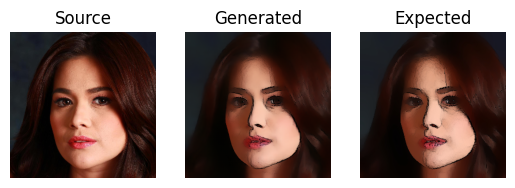

In [18]:
plot_images(src_image, gen_image, tar_image)

As we can see fromthe above plots, the generated image is not that much different from the expected cartoonized image. Meaning that the generator is able to generate cortoonized enough images.

# Test generator on an unseen image

In [19]:
from numpy import load
from numpy import expand_dims

We create a function to load and preprocess new images to be passed to the model

In [20]:
# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels


In [27]:
# load test image
test_image = load_image('/content/gdrive/MyDrive/comp_vision_project/photo_cv.jpeg')
print('Loaded', test_image.shape)

Loaded (1, 256, 256, 3)


In [28]:
# generate cartoon from test image
gen_image = model.predict(src_image)

1/1 [==============================] - 0s 22ms/step


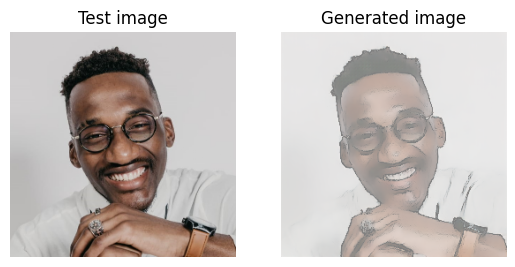

In [30]:
images = vstack((test_image, gen_image))
# scale from [-1,1] to [0,1]
images = (images + 1) / 2.0
titles = ['Test image', 'Generated image']
# plot images row by row
for i in range(len(images)):
  # define subplot
  pyplot.subplot(1, 2, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(images[i])
  # show title
  pyplot.title(titles[i])
pyplot.show()